In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA, AR, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error 

from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('zillow_data.csv')

In [3]:
df.head(9)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [4]:
df.dropna(inplace=True)

In [5]:
df_values=df.drop(columns=['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'])

In [6]:
df_values['Monthly Standard Deviation']=df_values.std(axis=1)

In [7]:
df_values.describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Monthly Standard Deviation
count,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,...,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04
mean,1.212036e+05,1.213271e+05,1.214490e+05,1.215684e+05,1.216994e+05,1.218514e+05,1.220502e+05,1.222816e+05,1.226310e+05,1.230788e+05,...,2.882930e+05,2.900502e+05,2.917727e+05,2.933964e+05,2.951143e+05,2.968218e+05,2.986880e+05,3.010316e+05,3.027098e+05,5.578342e+04
std,8.729561e+04,8.745386e+04,8.761246e+04,8.777632e+04,8.796517e+04,8.819306e+04,8.848098e+04,8.881847e+04,8.926276e+04,8.977167e+04,...,3.123781e+05,3.149425e+05,3.176656e+05,3.200350e+05,3.225833e+05,3.253281e+05,3.279814e+05,3.307702e+05,3.324853e+05,7.135107e+04
min,1.140000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,1.220000e+04,1.230000e+04,1.250000e+04,...,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04,2.020296e+03
25%,7.120000e+04,7.140000e+04,7.160000e+04,7.170000e+04,7.180000e+04,7.190000e+04,7.210000e+04,7.230000e+04,7.250000e+04,7.290000e+04,...,1.366000e+05,1.374000e+05,1.381500e+05,1.386500e+05,1.392000e+05,1.397000e+05,1.401000e+05,1.410000e+05,1.418000e+05,1.908575e+04
50%,1.022000e+05,1.023000e+05,1.023000e+05,1.024000e+05,1.025000e+05,1.025000e+05,1.027000e+05,1.029000e+05,1.031000e+05,1.035000e+05,...,2.025000e+05,2.037000e+05,2.052000e+05,2.064000e+05,2.076000e+05,2.085000e+05,2.098000e+05,2.115000e+05,2.130000e+05,3.524312e+04
75%,1.458000e+05,1.459000e+05,1.460000e+05,1.461000e+05,1.461000e+05,1.463000e+05,1.463000e+05,1.466000e+05,1.471000e+05,1.476000e+05,...,3.266000e+05,3.282000e+05,3.300500e+05,3.317500e+05,3.338000e+05,3.357000e+05,3.377000e+05,3.405500e+05,3.422000e+05,6.575038e+04
max,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,3.888900e+06,3.928800e+06,3.964600e+06,...,7.422400e+06,7.417600e+06,7.427300e+06,7.371400e+06,7.342700e+06,7.353300e+06,7.350300e+06,7.363000e+06,7.386600e+06,1.470204e+06


In [8]:
low_std=df_values[df_values['Monthly Standard Deviation']< 5.1785439e+05]

In [9]:
low_std

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Monthly Standard Deviation
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,190821.103965
1,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,33537.101427
2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,37730.794353
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,231225.944628
4,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,18167.079218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,136200.0,136600.0,136800.0,136800.0,136700.0,136600.0,136400.0,136000.0,135800.0,135800.0,...,332900,335600,338900,340500,341000,342300,345000,348000,349300,93886.550112
14718,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,...,217700,218600,218500,218100,216400,213100,209800,209200,209300,38411.628676
14719,92700.0,92500.0,92400.0,92200.0,92100.0,91900.0,91700.0,91300.0,90900.0,90500.0,...,208400,212200,215200,214300,213100,213700,218300,222700,225800,49298.400500
14720,57100.0,57300.0,57500.0,57700.0,58000.0,58200.0,58400.0,58700.0,59100.0,59500.0,...,122800,124600,126700,128800,130600,131700,132500,133000,133400,17772.324320


In [10]:
low_std.drop(columns=['Monthly Standard Deviation'],inplace=True)

In [39]:
low_std

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Average Monthly Percent Change,average montly
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,NaN,NaN
1,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,312500,314100,315000,316600,318100,319600,321100,321800,NaN,NaN
2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,320200,320400,320800,321200,321200,323000,326900,329900,NaN,NaN
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,NaN,NaN
4,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,120000,120300,120300,120300,120300,120500,121000,121500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,136200.0,136600.0,136800.0,136800.0,136700.0,136600.0,136400.0,136000.0,135800.0,135800.0,...,335600,338900,340500,341000,342300,345000,348000,349300,NaN,NaN
14718,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,...,218600,218500,218100,216400,213100,209800,209200,209300,NaN,NaN
14719,92700.0,92500.0,92400.0,92200.0,92100.0,91900.0,91700.0,91300.0,90900.0,90500.0,...,212200,215200,214300,213100,213700,218300,222700,225800,NaN,NaN
14720,57100.0,57300.0,57500.0,57700.0,58000.0,58200.0,58400.0,58700.0,59100.0,59500.0,...,124600,126700,128800,130600,131700,132500,133000,133400,NaN,NaN


In [52]:
low_std['Average Monthly Percent Change']=low_std.pct_change(axis=0).mean(axis=1)

In [53]:
low_std.describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Average Monthly Percent Change,average montly
count,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,...,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,12834.000000,0.0
mean,118472.216595,118585.703155,118697.350993,118805.851188,118924.994157,119063.412544,119245.827815,119458.472926,119784.160499,120204.939618,...,2.766333e+05,2.782240e+05,2.797418e+05,2.813558e+05,2.829459e+05,2.846986e+05,2.869363e+05,2.885607e+05,0.441670,NaN
std,71222.847981,71252.700594,71285.756500,71321.132790,71369.987296,71436.575798,71538.372236,71669.128156,71885.322543,72166.419279,...,2.381391e+05,2.400484e+05,2.418370e+05,2.437959e+05,2.458463e+05,2.478647e+05,2.500665e+05,2.514954e+05,1.438489,NaN
min,11400.000000,11500.000000,11600.000000,11800.000000,11800.000000,12000.000000,12100.000000,12200.000000,12300.000000,12500.000000,...,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04,-0.951167,NaN
25%,71000.000000,71150.000000,71300.000000,71500.000000,71600.000000,71800.000000,72000.000000,72100.000000,72400.000000,72700.000000,...,1.370500e+05,1.378500e+05,1.384500e+05,1.389000e+05,1.394000e+05,1.398000e+05,1.407500e+05,1.415000e+05,-0.414354,NaN
50%,101800.000000,102000.000000,102000.000000,102200.000000,102100.000000,102200.000000,102200.000000,102400.000000,102800.000000,103100.000000,...,2.030000e+05,2.042000e+05,2.053000e+05,2.066000e+05,2.075000e+05,2.088000e+05,2.108000e+05,2.124000e+05,0.027273,NaN
75%,145000.000000,145000.000000,145200.000000,145300.000000,145300.000000,145500.000000,145700.000000,145850.000000,146300.000000,146850.000000,...,3.255500e+05,3.275500e+05,3.296000e+05,3.314000e+05,3.331500e+05,3.355000e+05,3.380000e+05,3.399000e+05,0.758697,NaN
max,841900.000000,847400.000000,852700.000000,857600.000000,862300.000000,866700.000000,871000.000000,874900.000000,879600.000000,885000.000000,...,2.395400e+06,2.400900e+06,2.393300e+06,2.396100e+06,2.447500e+06,2.489000e+06,2.533000e+06,2.561200e+06,24.209253,NaN


In [55]:
low_std.sort_values(by=['Average Monthly Percent Change'],ascending=False)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Average Monthly Percent Change,average montly
4122,457100.0,457000.0,457500.0,458800.0,460900.0,463800.0,467500.0,472100.0,477300.0,482900.0,...,1919900,1946900,1990000,2047000,2094100,2123200,2151000,2170600,24.209253,NaN
13885,743100.0,746600.0,750000.0,753500.0,757100.0,761000.0,765600.0,770600.0,776900.0,784100.0,...,2395400,2400900,2393300,2396100,2409600,2430700,2448800,2458000,18.017147,NaN
13381,581800.0,585700.0,589600.0,592900.0,595500.0,597500.0,599300.0,601800.0,605900.0,610900.0,...,1084200,1058800,1041500,1041300,1046300,1048100,1050800,1059600,17.606177,NaN
1806,283300.0,284400.0,285700.0,286900.0,288100.0,289300.0,290600.0,291800.0,293400.0,295100.0,...,1221400,1224800,1230900,1238100,1242600,1248500,1259500,1266500,15.339865,NaN
7105,410400.0,410400.0,410400.0,410700.0,411200.0,411900.0,413100.0,414800.0,417100.0,420100.0,...,1576800,1579800,1577800,1587200,1601400,1616900,1639200,1654200,13.341330,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12837,59800.0,60300.0,60800.0,61300.0,61800.0,62400.0,63000.0,63600.0,64300.0,65000.0,...,106300,105100,104800,104800,104900,104800,105200,106000,-0.940297,NaN
13653,44800.0,45000.0,45300.0,45500.0,45700.0,45900.0,46200.0,46400.0,46800.0,47300.0,...,89600,89400,90200,92200,93900,93800,93000,92800,-0.942311,NaN
8694,27100.0,27200.0,27300.0,27400.0,27500.0,27600.0,27600.0,27700.0,27800.0,28000.0,...,57200,57500,58200,58800,58800,59200,60000,60500,-0.947345,NaN
13886,48400.0,48800.0,49200.0,49600.0,49900.0,50300.0,50800.0,51200.0,51700.0,52300.0,...,82100,82900,83700,84200,84100,85800,89900,93400,-0.951167,NaN


# Creating Baseline Model for my 5 zipcodes
I am going to create baseline models for my zipcodes using sarima modeling from statsmodels

In [95]:
el_passo93144=pd.DataFrame(df_values.iloc[4,:-2])

In [96]:
el_passo93144

,4
1996-04,77300.0
1996-05,77300.0
1996-06,77300.0
1996-07,77300.0
1996-08,77400.0
...,...
2017-11,120300.0
2017-12,120300.0
2018-01,120300.0
2018-02,120500.0


In [97]:
el_passo93144=el_passo93144.set_index(pd.to_datetime(el_passo93144.index))

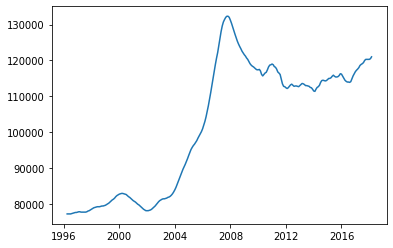

In [98]:
plt.plot(el_passo93144)

In [17]:
# deciding how i want to split up my training and test variables

In [18]:
len(el_passo93144)

264

In [99]:
el_passo93144.rename(columns={4:'value'},inplace=True)

In [100]:
X=el_passo93144['value']
train=X[:211]
test=X[211:]

In [21]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))


In [22]:
res=sarimax.fit(disp=False)

In [23]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                  211
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1547.851
Date:                            Mon, 20 Apr 2020   AIC                           3105.701
Time:                                    13:10:40   BIC                           3122.142
Sample:                                04-01-1996   HQIC                          3112.356
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8192      0.018     44.463      0.000       0.783       0.855
ma.L1         -0.5412      0.022    -24.601      0.000      -0.584      -0.498
ar.S.L12       0.1955      0.166      1.180      0.238      -0.129       0.520
ma.S.L12      -0.3879      0.176     -2.199      0.028      -0.734      -0.042
sigma2      1.451e+05    1.1e+04     13.254      0.000    1.24e+05    1.67e+05
===================================================================================
Ljung-Box (Q):                      266.50   Jarque-Bera (JB):               595.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.67
Prob(H) (two-sided):                  0.73   Kurtosis:                        11.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
pred_conf=forecast.conf_int()

#forecasttest=res.predict()

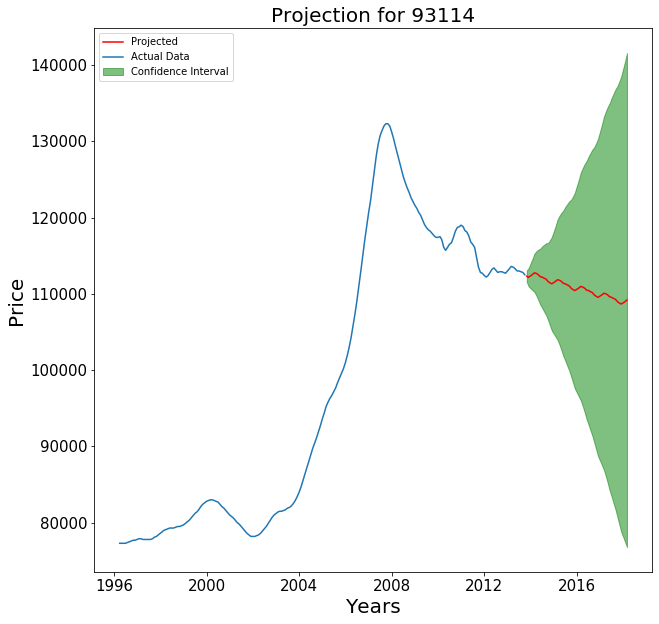

In [25]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red',label='Projected')
plt.plot(train,label='Actual Data')
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 93114',fontsize=20,)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5,label='Confidence Interval')
plt.legend(loc=2)

In [26]:
train[-1]

112500.0

In [27]:
forecast.predicted_mean[-1]

109192.37100253538

In [30]:
np.sqrt(mean_squared_error(test,forecast.predicted_mean))

6167.113264338686

# Second Zipcode

In [34]:
houston_91733=pd.DataFrame(df_values.iloc[5,:-2])

In [35]:
houston_91733

,5
1996-04,95000.0
1996-05,95200.0
1996-06,95400.0
1996-07,95700.0
1996-08,95900.0
...,...
2017-11,162800.0
2017-12,162800.0
2018-01,162800.0
2018-02,162900.0


In [36]:
houston_91733=houston_91733.set_index(pd.to_datetime(houston_91733.index))

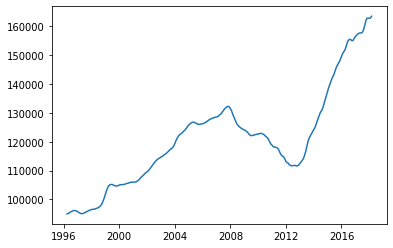

In [37]:
plt.plot(houston_91733)

In [38]:
len(houston_91733)
#print(len(houston_91733)*.8)

264

In [39]:
houston_91733.rename(columns={5:'value'},inplace=True)


In [40]:
X=houston_91733['value']
train=X[:211]
test=X[211:]


In [41]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

In [42]:
res=sarimax.fit(disp=False)

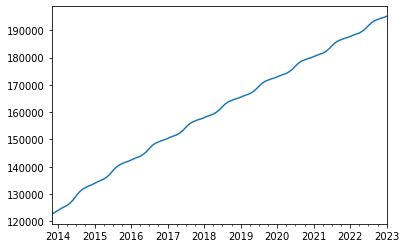

In [43]:
forecast=res.get_prediction(start=211,end=321,dynamic=True)
forecast.predicted_mean.plot()
pred_conf=forecast.conf_int()
#confidence interval

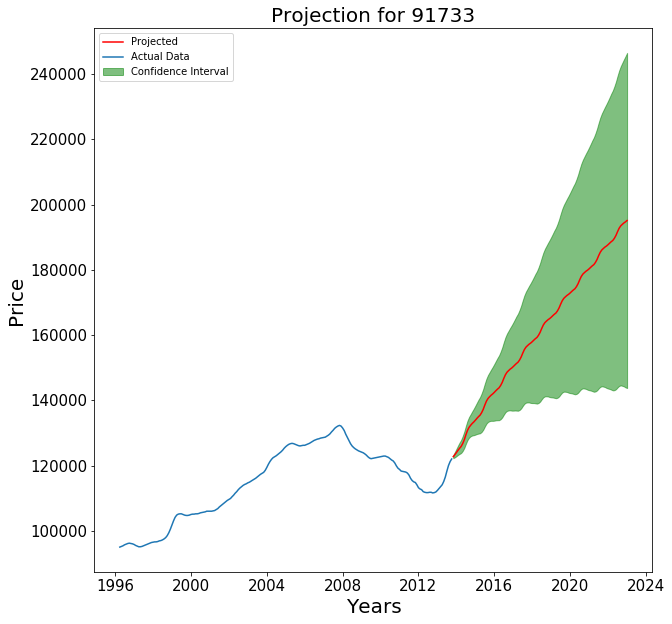

In [44]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red',label='Projected')
plt.plot(train,label='Actual Data')
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 91733',fontsize=20,)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5,label='Confidence Interval')
plt.legend(loc=2)

In [45]:
forecast.predicted_mean[-1]

195113.42955759726

In [46]:
np.sqrt(mse(test,forecast.predicted_mean))

NameError: name 'mse' is not defined

In [47]:
# 3rd zip code

In [48]:
Houston_91940=pd.DataFrame(df_values.iloc[8,:-2])

In [49]:
Houston_91940

,8
1996-04,95400.0
1996-05,95600.0
1996-06,95800.0
1996-07,96100.0
1996-08,96400.0
...,...
2017-11,170900.0
2017-12,172300.0
2018-01,173300.0
2018-02,174200.0


In [50]:
Houston_91940.rename(columns={8:'value'},inplace=True)

In [51]:
Houston_91940=Houston_91940.set_index(pd.to_datetime(Houston_91940.index))

In [52]:
print(len(Houston_91940)*.8)

211.20000000000002


In [53]:
X=Houston_91940['value']
train=X[:211]
test=X[211:]


In [54]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

In [55]:
res=sarimax.fit(disp=False)

In [56]:
forecast=res.get_prediction(start=211,end=324)
pred_conf=forecast.conf_int()

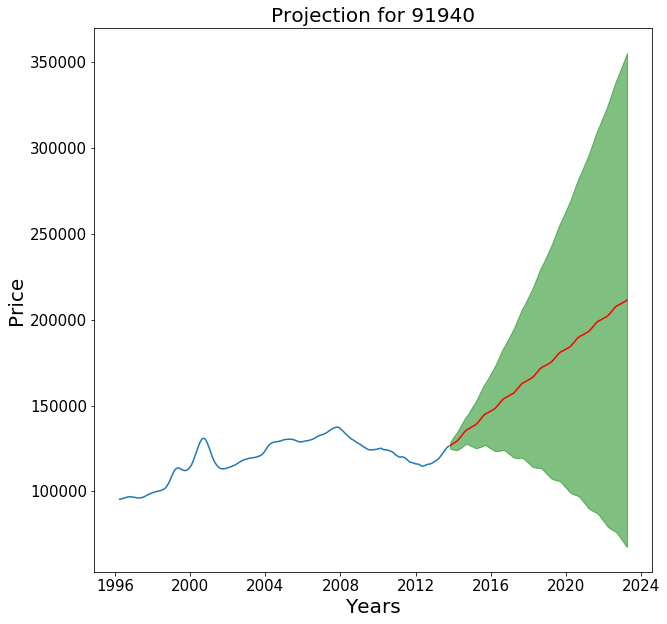

In [57]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 91940',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# zipcode 4

In [67]:
#identify seasonality 
#decompisition 


In [68]:
nashville_74101=pd.DataFrame(df_values.iloc[14,:-2])

In [69]:
nashville_74101.rename(columns={14:'value'},inplace=True)

In [70]:
nashville_74101=nashville_74101.set_index(pd.to_datetime(nashville_74101.index))

In [71]:
X=nashville_74101['value']
train=X[:211]
test=X[211:]


In [72]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

In [73]:
res=sarimax.fit(disp=False)

In [74]:
forecast=res.get_prediction(start=211,end=322)
pred_conf=forecast.conf_int()

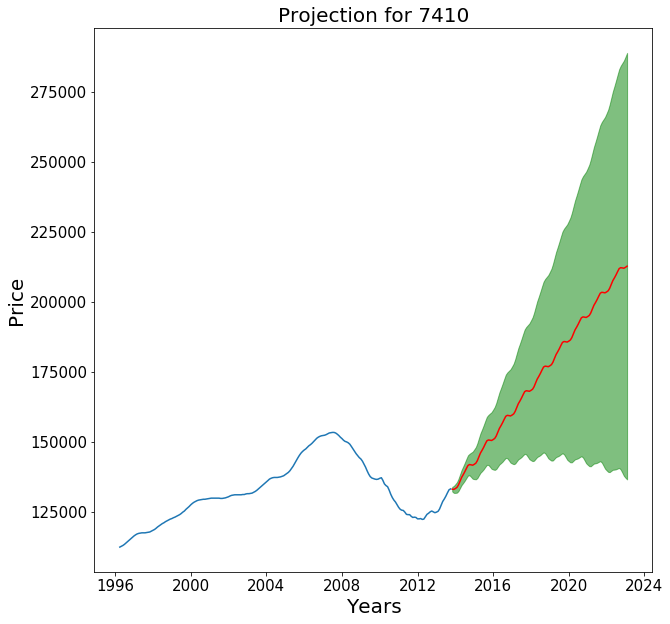

In [75]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 7410',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [76]:
(forecast.predicted_mean[-1]-train[-1])/train[-1]

0.5979603652079069

In [77]:
np.sqrt(mse(test,forecast))

NameError: name 'mse' is not defined

# zipcode 5

In [78]:
pfulugerville_78660=pd.DataFrame(df_values.iloc[18,:-2])

In [79]:
pfulugerville_78660.rename(columns={18:'value'},inplace=True)

In [80]:
pfulugerville_78660=pfulugerville_78660.set_index(pd.to_datetime(pfulugerville_78660.index))

In [81]:
X=pfulugerville_78660['value']
train=X[:211]
test=X[211:]


In [82]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

In [83]:
res=sarimax.fit(disp=False)

In [84]:
forecast=res.get_prediction(start=211,end=321)
pred_conf=forecast.conf_int()


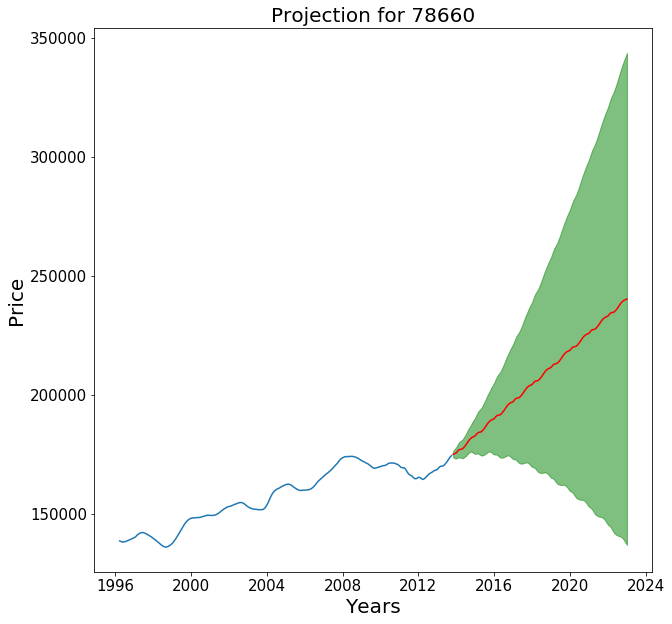

In [85]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 78660',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [86]:
np.sqrt(mse(test,forecast))

NameError: name 'mse' is not defined

In [ ]:
(forecast.predicted_mean[-1]-train[-1])/train[-1]

# Trying to improve baseline

I am going to use a grid search method for this

In [87]:
#zipcode 1

In [88]:
el_passo93144

,value
1996-04-01,77300.0
1996-05-01,77300.0
1996-06-01,77300.0
1996-07-01,77300.0
1996-08-01,77400.0
...,...
2017-11-01,120300.0
2017-12-01,120300.0
2018-01-01,120300.0
2018-02-01,120500.0


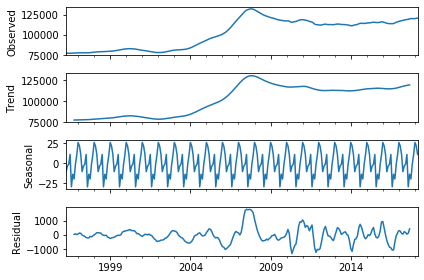

<Figure size 720x720 with 0 Axes>

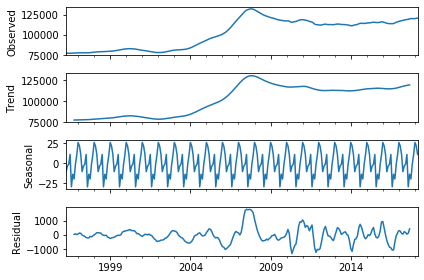

In [89]:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(el_passo93144, model='additive')
result.plot()

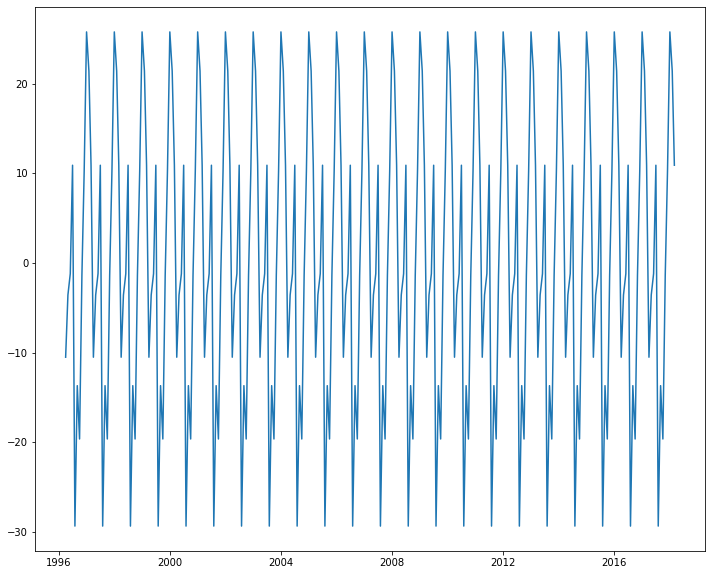

In [90]:
plt.figure(figsize=(12,10))
plt.plot(result.seasonal)

In [92]:
X=el_passo93144['value']
train=X[:211]
test=X[211:]

In [125]:
#Grid Search for my SARIMA params
ans = []
def params_SARIMA(data):
   
    p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

In [349]:
params_SARIMA(train)

In [351]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])


,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",5433.986662
1,"(0, 0, 0)","(0, 0, 1, 12)",5000.710714
2,"(0, 0, 0)","(0, 1, 0, 12)",4076.420779
3,"(0, 0, 0)","(0, 1, 1, 12)",3839.872758
4,"(0, 0, 0)","(1, 0, 0, 12)",4084.310508
5,"(0, 0, 0)","(1, 0, 1, 12)",4064.087261
6,"(0, 0, 0)","(1, 1, 0, 12)",3820.164847
7,"(0, 0, 0)","(1, 1, 1, 12)",3802.692163
8,"(0, 0, 1)","(0, 0, 0, 12)",5258.110408
9,"(0, 0, 1)","(0, 0, 1, 12)",4923.087899


In [107]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(0,0,0,12))

In [108]:
res=sarimax.fit(disp=False)

In [109]:
forecast=res.get_prediction(start=211,end=211,dynamic=True)
pred_conf=forecast.conf_int()

In [110]:
forecast

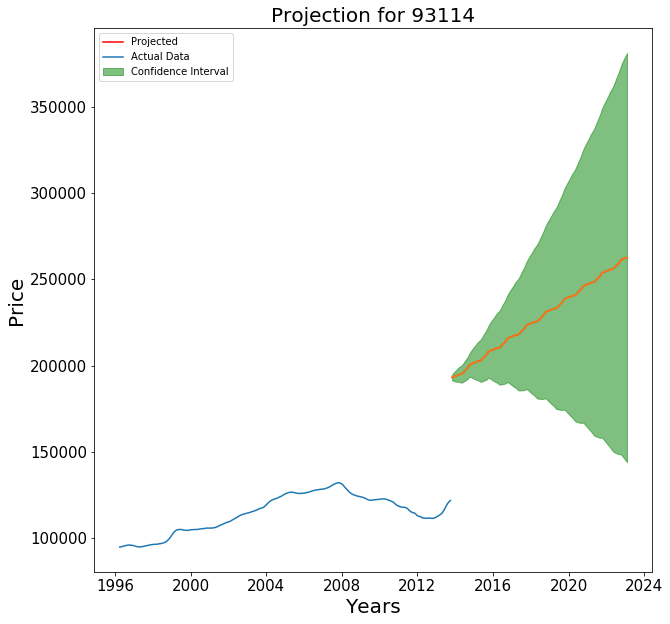

In [124]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red',label='Projected')
plt.plot(train,label='Actual Data')
plt.plot(forecast.predicted_mean)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 93114',fontsize=20,)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5,label='Confidence Interval')
plt.legend(loc=2)

In [413]:
np.sqrt(mse(test,forecast.predicted_mean))

6167.113264338686

In [444]:
el_passo93144

,value
1996-04-01,11.255449
1996-05-01,11.255449
1996-06-01,11.255449
1996-07-01,11.255449
1996-08-01,11.256742
...,...
2017-11-01,11.697744
2017-12-01,11.697744
2018-01-01,11.697744
2018-02-01,11.699405


# Replacing my first zip code

I decided to replace my first zipcode because the preidction was giv me negative returns


In [ ]:
df_values

In [112]:
leauge_city_77573=pd.DataFrame(df_values.iloc[22,:-2])

In [113]:
leauge_city_77573.rename(columns={23:'value'},inplace=True)

In [114]:
leauge_city_77573=leauge_city_77573.set_index(pd.to_datetime(leauge_city_77573.index))

In [115]:
X=leauge_city_77573['value']
train=X[:211]
test=X[211:]


In [116]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

In [117]:
res=sarimax.fit(disp=False)

In [118]:
forecast=res.get_prediction(start=211,end=322,dynamic=True)
pred_conf=forecast.conf_int()

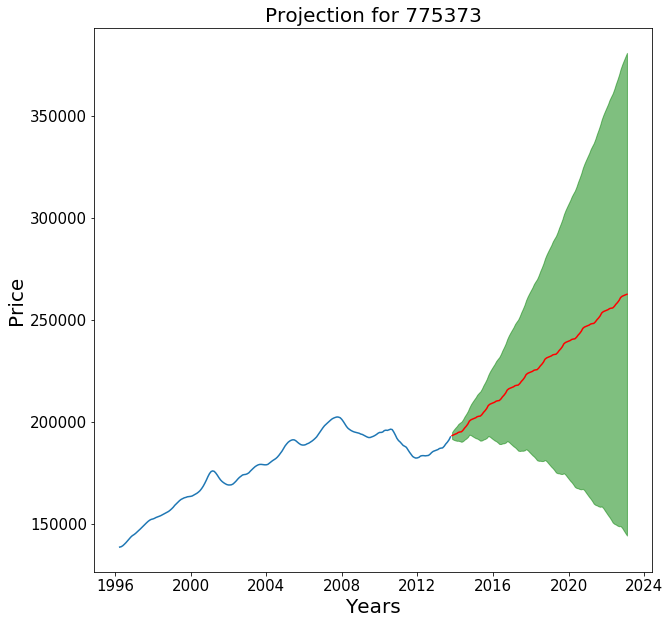

In [119]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 775373',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [122]:
# Second Zipcode

In [123]:
X=houston_91733['value']
train=X[:211]
test=X[211:]


In [128]:
params_SARIMA(train)

In [129]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])


In [134]:
ans_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",6910.078531
1,"(0, 0, 0)","(0, 0, 1, 12)",119680.167862
2,"(0, 0, 0)","(0, 1, 0, 12)",5096.388286
3,"(0, 0, 0)","(0, 1, 1, 12)",4861.388294
4,"(0, 0, 0)","(1, 0, 0, 12)",5041.794487
...,...,...,...
123,"(1, 1, 1)","(0, 1, 1, 12)",2437.243692
124,"(1, 1, 1)","(1, 0, 0, 12)",2567.134634
125,"(1, 1, 1)","(1, 0, 1, 12)",2556.021119
126,"(1, 1, 1)","(1, 1, 0, 12)",2510.839656


In [135]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2437.24
Name: 123, dtype: object

In [136]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,12))

In [137]:
res=sarimax.fit(disp=False)

In [142]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
pred_conf=forecast.conf_int()

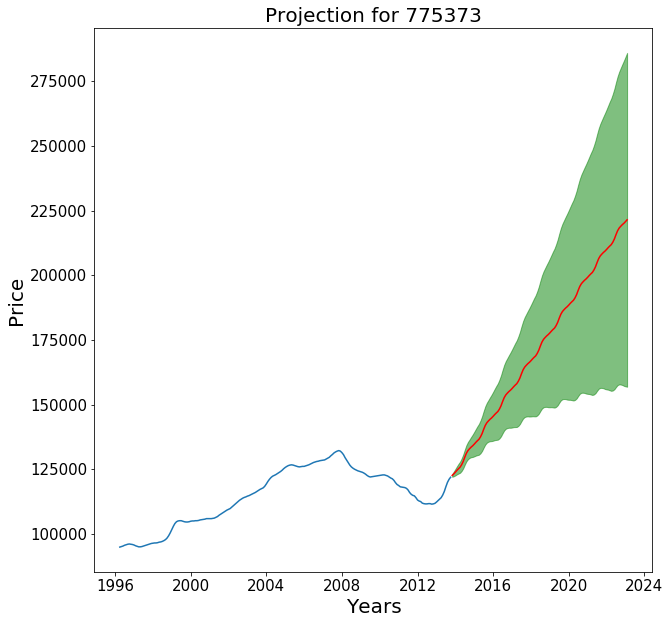

In [139]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 775373',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [143]:
np.sqrt(mean_squared_error(test,forecast.predicted_mean))

3003.6352712173934

In [144]:
# zipcode 3 

In [156]:
X=Houston_91940['value']
train=X[:211]
test=X[211:]

In [157]:
params_SARIMA(train)

In [147]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

In [148]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2437.24
Name: 123, dtype: object

In [158]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,12))

In [ ]:
res=sarimax.fit(disp=False)

In [159]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
pred_conf=forecast.conf_int()

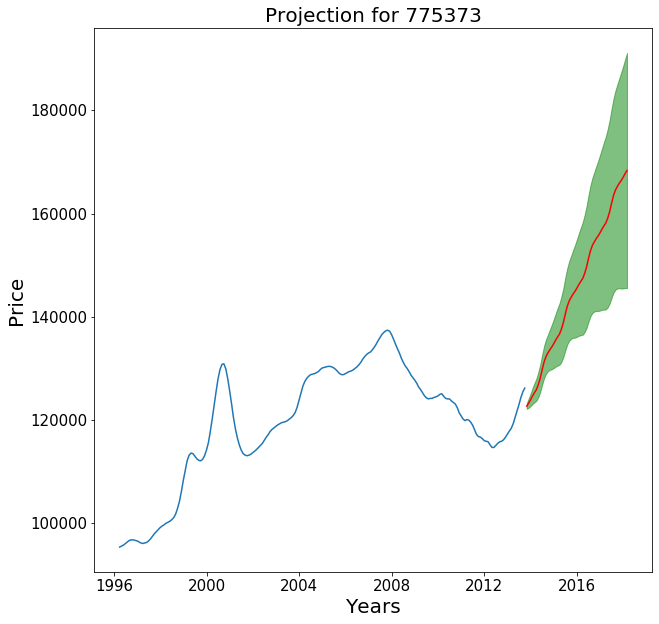

In [160]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 775373',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [161]:
np.sqrt(mean_squared_error(test,forecast.predicted_mean))

8957.685391514302

In [162]:
#zipcode 4

In [169]:
X=nashville_74101['value']
train=X[:211]
test=X[211:]


In [170]:
params_SARIMA(train)

In [171]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2437.24
Name: 123, dtype: object

In [172]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,12))

In [173]:
res=sarimax.fit(disp=False)

In [174]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
pred_conf=forecast.conf_int()

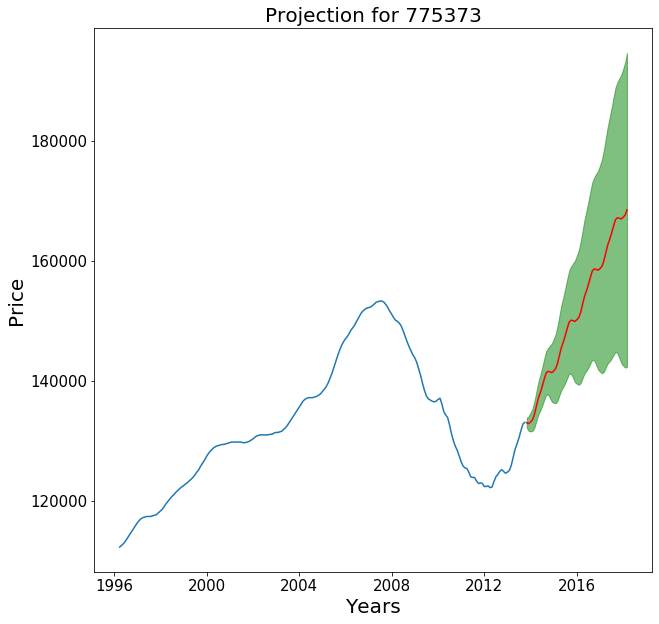

In [175]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 775373',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [176]:
np.sqrt(mean_squared_error(test,forecast.predicted_mean))

18659.55692982456

In [ ]:
# zipcode 5 

In [177]:
X=pfulugerville_78660['value']
train=X[:211]
test=X[211:]

In [178]:
params_SARIMA(train)

In [179]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2437.24
Name: 123, dtype: object

In [180]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,12))

In [181]:
res=sarimax.fit(disp=False)

In [182]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
pred_conf=forecast.conf_int()

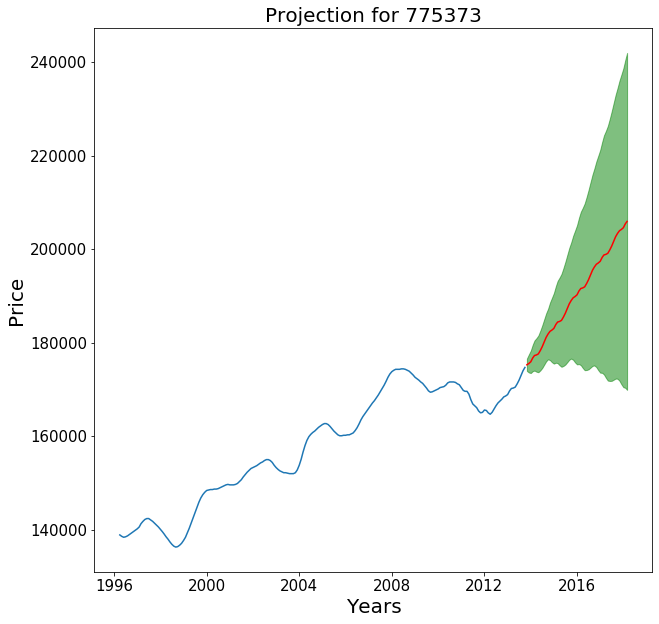

In [183]:
plt.figure(figsize=(10,10))
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.xlabel('Years',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Price',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Projection for 775373',fontsize=20)
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

In [184]:
np.sqrt(mean_squared_error(test,forecast.predicted_mean))

21249.384345234706